# Example of using NUTS

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from nuts_pytorch import nuts6

## Toy example

As an example let's choose the following two-dimensional target distribution
$$ p(x, y) = \exp\left( -20(y - x^2 - x - 1)^2 - x^2 \right). $$
This is a notoriously difficult distribution to sample, often used as a benchmark for sampling methods. For example, with plain Markov Chain Monte Carlo you'd have a bad time sampling this.

The `nuts6` function needs the logarithm of the target probability density function (PDF).

In [2]:
def target(theta):
    '''
    Arguments:
    - theta: variables of the PDF
    Returns:
    Log of the target PDF
    '''
    x, y = theta[0], theta[1]
    log_p = -20 * (y - x**2 - x - 1)**2 - x**2
    return log_p

Draw $1000$ samples from this distribution

find_reasonable_epsilon = 0.25


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19999/19999 [00:18<00:00, 1068.29it/s]


Final epsilon = 0.18086340676200907
samples.shape = torch.Size([10000, 2])


Text(0, 0.5, 'y')

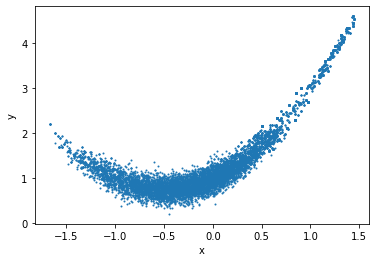

In [3]:
theta_0 = torch.tensor([0, 1]) # Initial point for the sampler
samples = nuts6(target, 10000, 10000, theta_0)
print('samples.shape =', samples.shape)
plt.scatter(*samples.T, s=1)
plt.xlabel('x')
plt.ylabel('y')

Now if you would plot the PDF you'd see that the samples cover the distribution nicely. Now we can compute, for example, the mean of the variables

In [4]:
samples.mean(axis=0)

tensor([0.0142, 1.4823], dtype=torch.float64)

These would be the approximations to the true means $E[X]$ and $E[Y]$ if $(X,Y)$ followed the distribution $p(x,y)$.